
## 데이터 https://goo.gl/s8qSL5

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer
%matplotlib inline

In [3]:
train = pd.read_csv("data/bike_train.csv", parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


## datetime 데이터 분해

In [5]:
train["d-year"] = train["datetime"].dt.year
train["d-month"] = train["datetime"].dt.month
train["d-day"] = train["datetime"].dt.day
train["d-hour"] = train["datetime"].dt.hour
train["d-minute"] = train["datetime"].dt.minute
train["d-second"] = train["datetime"].dt.second

train[["datetime", "d-year", "d-month", "d-day", "d-hour", "d-minute", "d-second"]].head()

,datetime,d-year,d-month,d-day,d-hour,d-minute,d-second
0,2011-01-01 00:00:00,2011,1,1,0,0,0
1,2011-01-01 01:00:00,2011,1,1,1,0,0
2,2011-01-01 02:00:00,2011,1,1,2,0,0
3,2011-01-01 03:00:00,2011,1,1,3,0,0
4,2011-01-01 04:00:00,2011,1,1,4,0,0


<AxesSubplot:xlabel='d-hour', ylabel='count'>

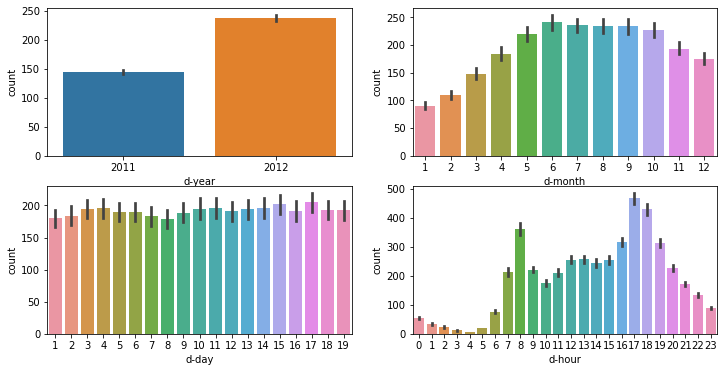

In [6]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(12, 6)

sns.barplot(data=train, x="d-year", y="count", ax=ax1)
sns.barplot(data=train, x="d-month", y="count", ax=ax2)
sns.barplot(data=train, x="d-day", y="count", ax=ax3)
sns.barplot(data=train, x="d-hour", y="count", ax=ax4)

## 시간대별 평균 대여수 (주중, 주말 구분)

<AxesSubplot:xlabel='d-hour', ylabel='count'>

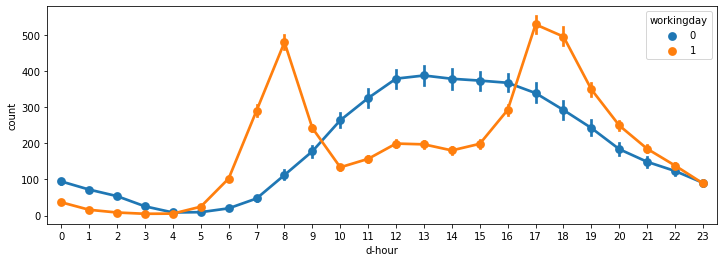

In [7]:
plt.figure(figsize=(12,4))
sns.pointplot(data=train, x="d-hour", y="count", hue="workingday")

## 시간대별 대여수 - 요일 구분

In [8]:
train["d-dayofweek"] = train["datetime"].dt.dayofweek

print(train.shape)
train[["datetime", "d-dayofweek"]].head()

(10886, 19)


,datetime,d-dayofweek
0,2011-01-01 00:00:00,5
1,2011-01-01 01:00:00,5
2,2011-01-01 02:00:00,5
3,2011-01-01 03:00:00,5
4,2011-01-01 04:00:00,5


<AxesSubplot:xlabel='d-hour', ylabel='count'>

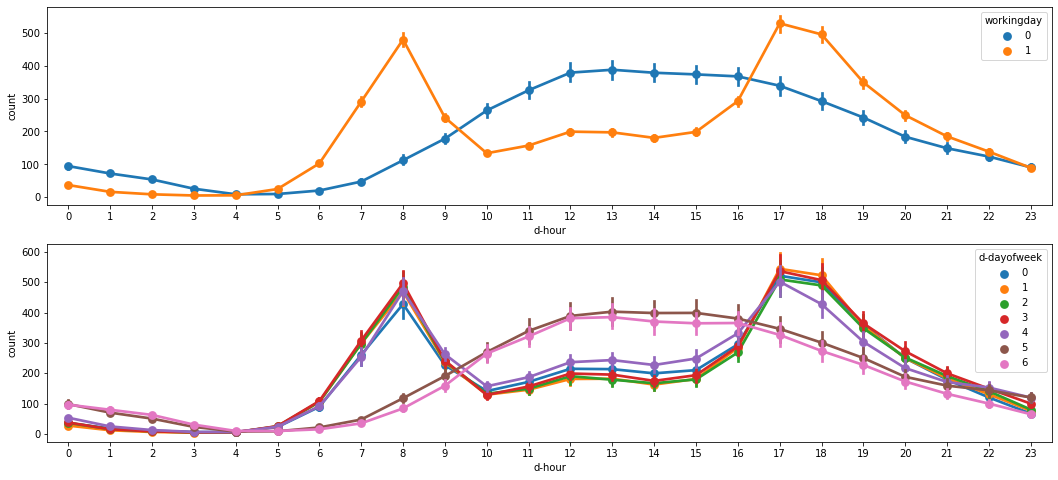

In [9]:
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18, 8)

sns.pointplot(data=train, x="d-hour", y="count", hue="workingday", ax=ax1)
sns.pointplot(data=train, x="d-hour", y="count", hue="d-dayofweek", ax=ax2)

## 연도와 월을 합한 특성 변수 생성

In [10]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train["d-year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", "d-year_month"]].head()

(10886, 20)


,datetime,d-year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


<AxesSubplot:xlabel='d-year_month', ylabel='count'>

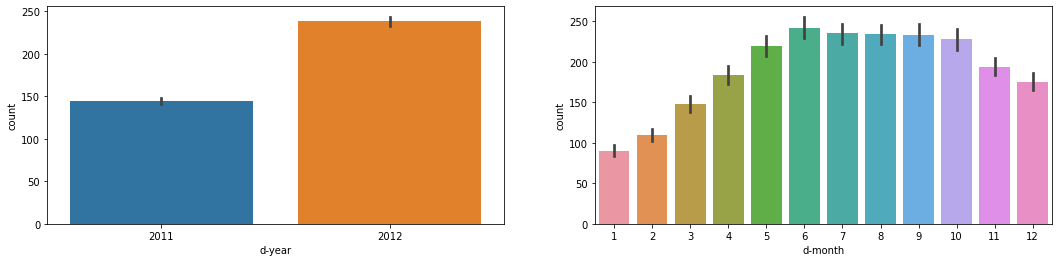

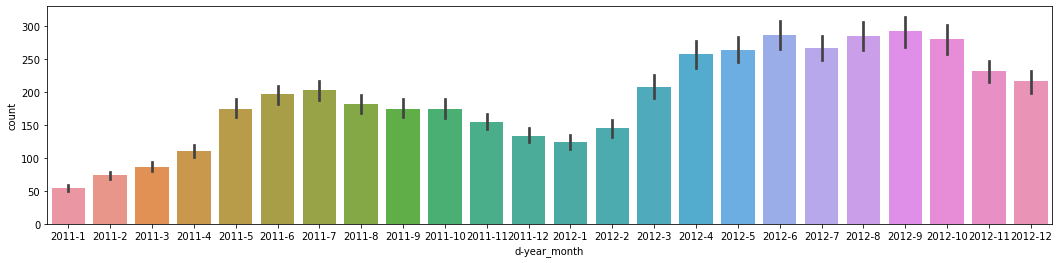

In [11]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 4)

sns.barplot(data=train, x="d-year", y="count", ax=ax1)
sns.barplot(data=train, x="d-month", y="count", ax=ax2)

figure, ax3 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)

sns.barplot(data=train, x="d-year_month", y="count", ax=ax3)

## 훈련에 사용할 특성 선택

In [12]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'd-year', 'd-month', 'd-day', 'd-hour', 'd-minute', 'd-second',
       'd-dayofweek', 'd-year_month'],
      dtype='object')

In [13]:
features = ["season", "holiday", "workingday", "weather",
                 "temp", "atemp", "humidity", "windspeed",
                 "d-year", "d-hour", "d-dayofweek"]

In [14]:
X = train[features]
print(X.shape)
X.head()

(10886, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,d-year,d-hour,d-dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0,2011,2,5
3,1,0,0,1,9.84,14.395,75,0.0,2011,3,5
4,1,0,0,1,9.84,14.395,75,0.0,2011,4,5


In [15]:
y = train["count"]
print(y.shape)

(10886,)


In [16]:
# import numpy as np
# y_train = np.log(y_train + 1)

# print(y_train.shape)
# y_train.head()

## 간단한 예측 모델

In [17]:
# model = RandomForestRegressor(n_estimators= 30)
# score = cross_val_score(model, X, y, cv=5).mean()
# score

In [18]:
# model = LinearRegression()
# score = cross_val_score(model, X, y, cv=5).mean()
# score

In [19]:
np.random.seed(11)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [20]:
model = RandomForestRegressor(n_estimators= 30)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9483758264489849

In [21]:
list(zip(y_test, model.predict(X_test)))[:10]

[(6, 7.066666666666666),
 (42, 47.8),
 (610, 527.7666666666667),
 (16, 18.733333333333334),
 (70, 79.9),
 (14, 25.433333333333334),
 (415, 369.7),
 (232, 225.6),
 (237, 330.1666666666667),
 (290, 278.3)]

In [22]:
X_train[:5]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,d-year,d-hour,d-dayofweek
7560,2,0,1,3,22.14,25.760,88,19.0012,2012,9,0
8090,2,0,0,1,25.42,31.060,57,7.0015,2012,11,6
30,1,0,0,2,16.40,20.455,76,12.9980,2011,7,6
7290,2,0,1,2,18.86,22.725,88,0.0000,2012,3,3
8665,3,0,1,2,32.80,37.120,52,12.9980,2012,10,4


## 선형회귀

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.3756193424788409

In [24]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9031443487303448

## 성능 지표( score) 함수 변경

In [25]:
def rmsle(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
    
    log_predict = predict + 1
    log_actual = actual + 1
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()    
    score = np.sqrt(mean_difference)
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## 하이퍼파라미터 선택

### 그리드 탐색

In [45]:
n_estimators = 30

max_depth_list = [10, 20, 30]
max_features_list = [0.3, 0.5, 0.9]

hyperparameters_list = []

for max_depth in max_depth_list:
    for max_features in max_features_list:
        model = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      max_features=max_features,
                                      random_state=11,
                                      n_jobs=-1)

        score = cross_val_score(model, X_train, y_train, cv=10, \
                                scoring=rmsle_scorer).mean()

        hyperparameters_list.append({
            'score': score,
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'max_features': max_features,
        })

        print("Score = {0:.5f}".format(score))

hyperparameters_list

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

[{'score': nan, 'n_estimators': 30, 'max_depth': 10, 'max_features': 0.3},
 {'score': nan, 'n_estimators': 30, 'max_depth': 10, 'max_features': 0.5},
 {'score': nan, 'n_estimators': 30, 'max_depth': 10, 'max_features': 0.9},
 {'score': nan, 'n_estimators': 30, 'max_depth': 20, 'max_features': 0.3},
 {'score': nan, 'n_estimators': 30, 'max_depth': 20, 'max_features': 0.5},
 {'score': nan, 'n_estimators': 30, 'max_depth': 20, 'max_features': 0.9},
 {'score': nan, 'n_estimators': 30, 'max_depth': 30, 'max_features': 0.3},
 {'score': nan, 'n_estimators': 30, 'max_depth': 30, 'max_features': 0.5},
 {'score': nan, 'n_estimators': 30, 'max_depth': 30, 'max_features': 0.9}]

In [47]:
hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

(9, 4)


,score,n_estimators,max_depth,max_features
0,NaN,30,10,0.3
1,NaN,30,10,0.5
2,NaN,30,10,0.9
3,NaN,30,20,0.3
4,NaN,30,20,0.5


### 랜덤 탐색

In [56]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

hyperparameters_list = []

n_estimators = 30
num_epoch = 10

for epoch in range(num_epoch):
    max_depth = np.random.randint(low=2, high=100)
    max_features = np.random.uniform(low=0.1, high=1.0)

    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  random_state=37,
                                  n_jobs=-1)

    score = cross_val_score(model, X_train, y_train, cv=20, \
                            scoring=rmsle_scorer).mean()

    hyperparameters_list.append({
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    })

    print("Score = {0:.5f}".format(score))

hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan
(10, 4)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

,score,n_estimators,max_depth,max_features
0,NaN,30,76,0.804363
1,NaN,30,38,0.269277
2,NaN,30,61,0.251480
3,NaN,30,48,0.128580
4,NaN,30,21,0.543362


### 상세 탐색

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

hyperparameters_list = []

n_estimators = 10
num_epoch = 10

for epoch in range(num_epoch):
    max_depth = np.random.randint(low=10, high=70)
    max_features = np.random.uniform(low=0.4, high=1.0)

    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  random_state=37,
                                  n_jobs=-1)

    score = cross_val_score(model, X_train, y_train, cv=20, \
                            scoring=rmsle_scorer).mean()

    hyperparameters_list.append({
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    })

    print("Score = {0:.5f}".format(score))

hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

## 최종 모델 선택

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=3000,
                              max_depth=83,
                              max_features=0.851358,
                              random_state=37,
                              n_jobs=-1)
model

## Score (lmsle)

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

In [ ]:
from sklearn.cross_validation import cross_val_score

score = cross_val_score(model, X_train, y_train, cv=5,
                        scoring=rmsle_scorer).mean()

print("Score = {0:.5f}".format(score))

## Train

In [ ]:
model.fit(X_train, y_train)

In [ ]:
list(zip(features, model.feature_importances_))

In [ ]:
df = pd.DataFrame(list(zip(features, model.feature_importances_)))

# -------------연습장--------------

In [29]:
#선형 회귀
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)  #R 스퀘어: 결정계수  #0.37 : 결정계수가 낮다. 선형회귀가 맞지 않다

0.3756193424788409

In [30]:
model = DecisionTreeRegressor()  #반대로 의사결정나무로 하면 스코어가 높다
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9046517825320413

In [42]:
#rmsle 라는 것을 가지고 평가를 하다, 문제를 풀때 rmsle를 가지고 적은지 큰지 평가를 하면서 모델을 만들다
#채점 기준에 맞추기 위해서 이다.
def rmsle(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
    
    log_predict = predict + 1
    log_actual = actual + 1
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    score = np.sqrt(mean_difference)
    return score

rmsle_scorer = make_scorer(rmsle) #방금 만든rmsle를 인자로 해서 make_score로 하면 새로운 점수 등록기가 된다.
rmsle_scorer

#사용자가 정리한 평가지표를 만들다

make_scorer(rmsle)

In [36]:
np.random,seed(11)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

NameError: name 'seed' is not defined

In [34]:
np.random.seed(11)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [37]:
model = RandomForestRegressor(n_estimators= 30)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9483758264489849

In [40]:
#그리드 탐색
n_estimators =30

max_depth_list = [10, 20, 30]  #3가지
max_feature_list = [0.3, 0.5 , 0.9]  #3가지 경우의 수에 대해서 하겠다
#총 9개 경우의 수가 나오다
hyperparameters_list = []


#9개 경우의 수를 for문을 통해 돌리겠다
for max_depth in max_depth_list:
    for max_features in max_features_list:
        model = RandomForestRegressor(n_estimators=n_estimators,
                                     max_depth=max_depth,
                                     max_features=max_features,
                                     random_state=11,
                                     n_jobs=-1)
        
        score = cross_val_score(model, X_train, y_train, cv=10, \
                               scoring=rmsle_scorer).mean()
        
        hyperparameters_list.append({
            'score': score,
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'max_features': max_features,
        })
        
        print("Score = {0:.5f}".format(score))
        
hyperparameters_list

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


[{'score': nan, 'n_estimators': 30, 'max_depth': 10, 'max_features': 0.3},
 {'score': nan, 'n_estimators': 30, 'max_depth': 10, 'max_features': 0.5},
 {'score': nan, 'n_estimators': 30, 'max_depth': 10, 'max_features': 0.9},
 {'score': nan, 'n_estimators': 30, 'max_depth': 20, 'max_features': 0.3},
 {'score': nan, 'n_estimators': 30, 'max_depth': 20, 'max_features': 0.5},
 {'score': nan, 'n_estimators': 30, 'max_depth': 20, 'max_features': 0.9},
 {'score': nan, 'n_estimators': 30, 'max_depth': 30, 'max_features': 0.3},
 {'score': nan, 'n_estimators': 30, 'max_depth': 30, 'max_features': 0.5},
 {'score': nan, 'n_estimators': 30, 'max_depth': 30, 'max_features': 0.9}]

In [43]:

n_estimators = 30

max_depth_list = [10, 20, 30]
max_features_list = [0.3, 0.5, 0.9]

hyperparameters_list = [] #처음에 빈통을 만들다


#gridSearch cv라는 함수도 있지만 직접 for문으로 찾아보다.
for max_depth in max_depth_list:
    for max_features in max_features_list:
        model = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      max_features=max_features,
                                      random_state=11,
                                      n_jobs=-1)

        score = cross_val_score(model, X_train, y_train, cv=5, 
                                scoring=rmsle_scorer).mean()
#cross_val_score(~~~): X_train을 5개로 쪼개서, 그 중에1개만 validation(자체 검증)으로 쓰고
#4개는 훈련용으로 쓰는 것을 5번 반복하겠다
#그렇게 하되, 점수는 아까 만들었던 rmsle_scorer으로 return  하겠다.
#여기서 점수는 낮을 수록 좋다.  rmsle: 오차 자승의 루트 합 이기에, 오차가 작을 수록 좋다

        hyperparameters_list.append({#루프를 한번 돌 때마다 append가 실행된다.
            'score': score,
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'max_features': max_features,
        })

        print("Score = {0:.5f}".format(score))

hyperparameters_list

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

Score = nan
Score = nan


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 973, in __call__
    n_jobs = self._initialize_backend()
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\parallel.py", line 740, in _initialize_backend
    n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\_parallel_backends.py", line 494, in configure
 

[{'score': nan, 'n_estimators': 30, 'max_depth': 10, 'max_features': 0.3},
 {'score': nan, 'n_estimators': 30, 'max_depth': 10, 'max_features': 0.5},
 {'score': nan, 'n_estimators': 30, 'max_depth': 10, 'max_features': 0.9},
 {'score': nan, 'n_estimators': 30, 'max_depth': 20, 'max_features': 0.3},
 {'score': nan, 'n_estimators': 30, 'max_depth': 20, 'max_features': 0.5},
 {'score': nan, 'n_estimators': 30, 'max_depth': 20, 'max_features': 0.9},
 {'score': nan, 'n_estimators': 30, 'max_depth': 30, 'max_features': 0.3},
 {'score': nan, 'n_estimators': 30, 'max_depth': 30, 'max_features': 0.5},
 {'score': nan, 'n_estimators': 30, 'max_depth': 30, 'max_features': 0.9}]

In [49]:
#위의 결과를 보기 좋게 정리하다
hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()



(9, 4)


,score,n_estimators,max_depth,max_features
0,NaN,30,10,0.3
1,NaN,30,10,0.5
2,NaN,30,10,0.9
3,NaN,30,20,0.3
4,NaN,30,20,0.5


In [ ]:
hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

In [57]:
#랜덤 선택
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

hypermeters_list =[]

n_estimators = 30
num_epoch = 10

for epoch in range(num_epoch):
    max_depth = np.random.randint(low=2, high=100)  #2부터 100까지 랜덤한 정수로 뽑다  트리의 깊이를 정하다 
    max_features = np.random.uniform(low=0.1, high=1.0) #0.1 = 10% 사용, 1.0 = 100% 사용
    
    model = RandomForestRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 max_features=max_features,
                                 random_state=37,
                                 n_jobs=-1)
    
    score = cross_val_score(model, X_train, y_train, cv=20, \
                            scoring=rmsle_scorer).mean()
    
    hyperparameters_list.append({
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    })
    
    print("Score = {0: .5f}".format(score))
    
hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

ModuleNotFoundError: No module named 'sklearn.cross_validation'

In [58]:
# 최종 모델 선택

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=300,
                             max_depth=83,
                             max_features=0.851358,
                             random_state=37,
                             n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=83, max_features=0.851358, n_estimators=300,
                      n_jobs=-1, random_state=37)